Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en `Material_TPs/TP3/images` a partir del template `Material_TPs/TP3/template`

1. (4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos
2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen
coca_multi.png con el mismo témplate del ítem 1
3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes.

Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza de la detección.

In [993]:
#%matplotlib inline
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os

In [994]:
def show_gray_img(img):
    plt.imshow(img, cmap='gray')
    # plt.axis("off")
    plt.show()

def show_bgr_img(img):
    plt.imshow(img[..., ::-1])
    # plt.axis("off")
    plt.show()

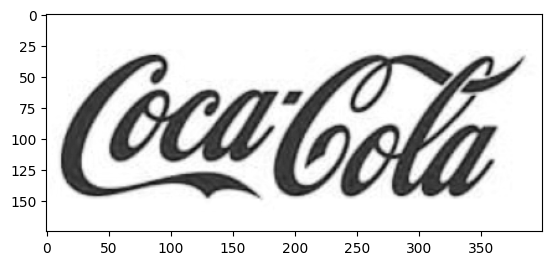

In [995]:
TEMPLATE_PATH = 'material/template/pattern.png'
template = cv.imread(TEMPLATE_PATH, 0)
show_gray_img(template)

In [996]:
METHODS = [
    'cv.TM_CCOEFF_NORMED',
    'cv.TM_CCORR_NORMED',
    'cv.TM_SQDIFF_NORMED',
]

In [997]:
def check_sizes(template, img):
    if template.shape[0] > img.shape[0] or template.shape[1] > img.shape[1]:
        raise Exception('Invalid template size')

def do_template_matching(template, img_gray, method):
    check_sizes(template, img_gray)
    res = cv.matchTemplate(img_gray, template, eval(method))
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)

    if method == 'cv.TM_SQDIFF_NORMED':
        top_left = min_loc
        max_val_ncc = 1 - min_val
    else:
        top_left = max_loc
        max_val_ncc = max_val

    return max_val_ncc, top_left

def get_bottom_right(top_left, template):
    w, h = template.shape[::-1]
    return int(top_left[0] + w), int(top_left[1] + h)

def draw_text(img, top_left, acc, color=(255, 0, 0)):
    label = f'Confianza: {int(acc * 100)}%'
    (label_width, label_height), _ = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 1, 2)

    text_start = (top_left[0], top_left[1] - label_height)
    text_end = (top_left[0] + label_width, top_left[1])

    font_scale = 1
    if text_end[0] > img.shape[1]:
        font_scale = 0.5

    cv.rectangle(img, text_start, text_end, (0,0,0),-1)
    cv.putText(img, label, top_left, cv.FONT_HERSHEY_SIMPLEX, font_scale, color, 2, cv.LINE_AA)

    return img

def draw_rectangle(img, top_left, bottom_right, acc, color=(255, 0, 0), thickness=3):
    cv.rectangle(img, top_left, bottom_right, color, thickness)
    draw_text(img, top_left, acc, color)
    return img

In [998]:
def preprocess_image(img, scale):
    scaled_img = cv.resize(img, None, fx=scale, fy=scale)
    canny_img = cv.Canny(scaled_img, 50, 250, apertureSize=3)
    return canny_img

def preprocess_templ(img):
    canny_img = cv.Canny(img, 200, 200, apertureSize=3)
    return canny_img

In [999]:
def match_template_alg(image, template):
    img_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    i_scales = np.linspace(0.1, 3.0, 15)[::-1]

    images = list()

    for scale in i_scales:
        images.append(preprocess_image(img_gray, scale))

    templ = preprocess_templ(template)

    best_match = None

    for meth in METHODS:
        for i_scale_index, img_to_compare in enumerate(images):
            try:
                max_val_ncc, top_left = do_template_matching(templ, img_to_compare, meth)
                if best_match is None or max_val_ncc >= best_match['acc']:
                    bottom_right = get_bottom_right(top_left, templ)
                    best_match = {
                        'acc': max_val_ncc,
                        'top_left': top_left,
                        'bottom_right': bottom_right,
                        'i_scale_index': i_scale_index,
                        'method': meth,
                    }
            except Exception:
                pass

    if best_match is None:
        raise Exception('No match found')

    output_image = cv.resize(image, None, fx=i_scales[best_match['i_scale_index']], fy=i_scales[best_match['i_scale_index']])
    draw_rectangle(output_image, best_match['top_left'], best_match['bottom_right'], best_match['acc'])

    return output_image

Ejercicio 1
(La imagen de coca_multi.png esta usando un best_match que termina señalando un rectangulo que no es el mejor para ese caso. Si se fuerza para que use el metodo de TM_CCOEFF_NORMED, el resultado es bastante mejor. O, se puede obtener un mejor resultado usando el codigo del ej 2.)

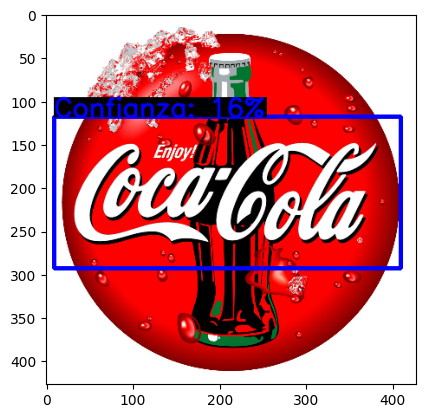

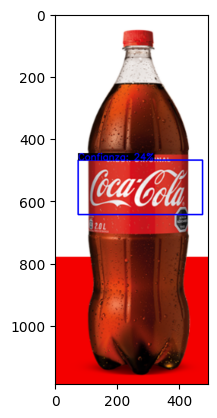

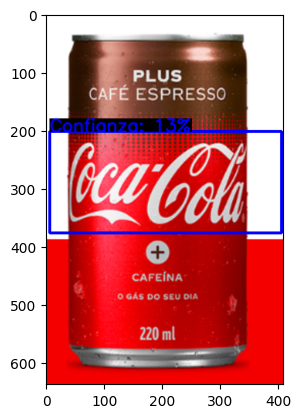

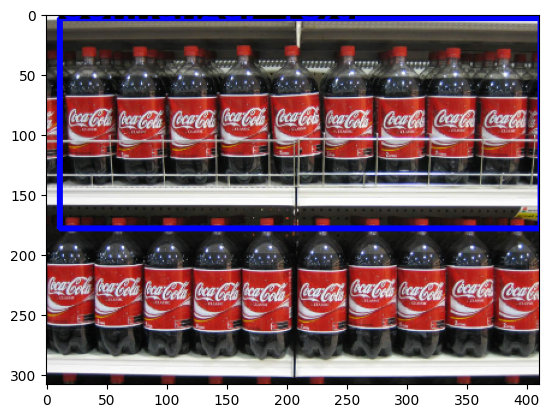

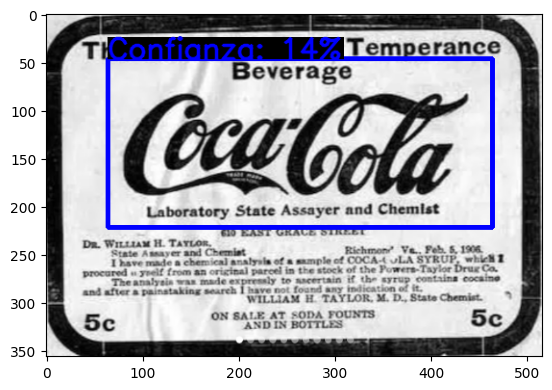

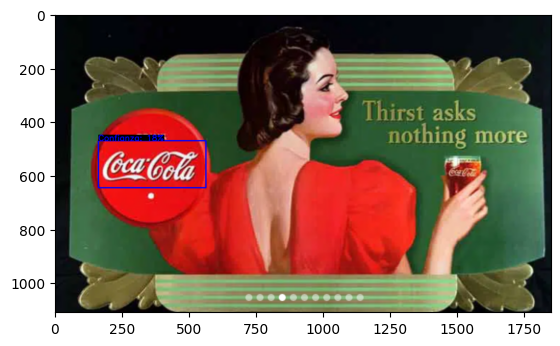

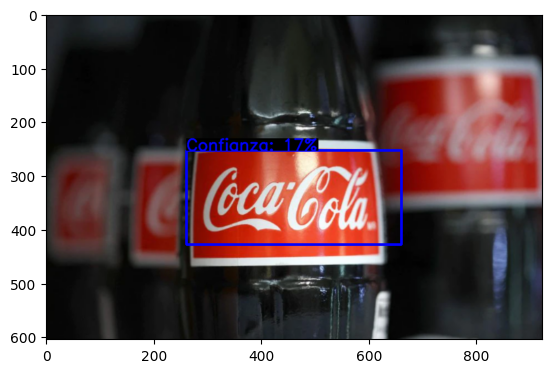

In [988]:
IMAGES_PATH = 'material/images'

for filename in sorted(os.listdir(IMAGES_PATH)):
    f = os.path.join(IMAGES_PATH, filename)
    img = cv.imread(f)
    result = match_template_alg(img, template)
    if result is not None:
        show_bgr_img(result)
    else:
        print(f'No result for {f}')

Ejercicio 2

In [989]:
def remove_overlapping_matches(matches):
    to_keep = list()
    while len(matches) > 0:
        rect_1, acc_1 = matches.pop(0)
        overlapped = False
        for rect, acc in to_keep:
            if do_overlap(*rect_1, *rect):
                overlapped = True
                break
        if not overlapped:
            to_keep.append((rect_1, acc_1))
    return to_keep

def do_overlap(tl1, br1, tl2, br2):
    if tl1[0] >= br2[0] or br1[0] <= tl2[0] or br1[1] <= tl2[1] or tl1[1] >= br2[1]:
        return False
    return True

In [990]:
def draw_multi_text(img, top_left, acc, color=(255, 0, 0)):
    label = f'{int(acc * 100)}%'
    cv.putText(img, label, top_left, cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 2, cv.LINE_AA)

    return img

In [991]:
def multi_match_template(img, template, method, template_scale, image_scale, threshold):

    processed_template = preprocess_image(template, template_scale)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    processed_image = preprocess_image(img_gray, image_scale)

    res = cv.matchTemplate(processed_image, processed_template, eval(method))

    loc = np.where(res >= threshold)
    output_image = img.copy()

    matches = list()
    for pt in zip(*loc[::-1]):
        top_left = int(pt[0]/image_scale), int(pt[1]/image_scale)
        bottom_right = get_bottom_right(top_left, processed_template)
        matches.append(((top_left, bottom_right), res[pt[::-1]]))

    matches = remove_overlapping_matches(matches)

    for (top_left, bottom_right), acc in matches:
        cv.rectangle(output_image, top_left, bottom_right, (255, 0, 0), 2)
        draw_multi_text(output_image, top_left, acc)

    return output_image

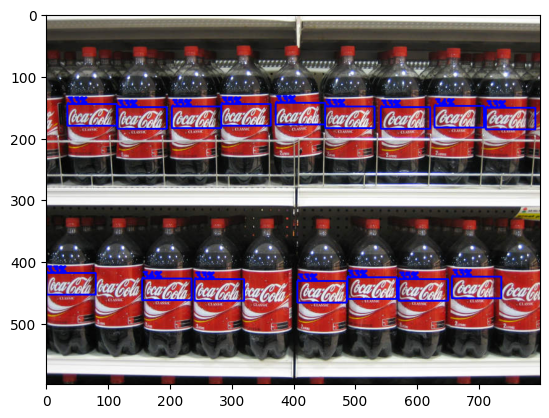

In [992]:
image = cv.imread('material/images/coca_multi.png')
method = "cv.TM_CCORR_NORMED"
template_scale = 0.2
image_scale = 1.0

show_bgr_img(multi_match_template(image, template, method, template_scale, image_scale, 0.33))